Starting Data Analysis Script...
Data Preparation Complete. Starting Analysis.

--- [Result 1] Overall Performance by Market Sentiment ---
                            Total_PnL  Average_Daily_PnL  Total_Trades   Total_Volume  Average_Daily_Win_Rate  Number_of_Days
Sentiment Classification                                                                                                     
Extreme Fear               739,110.25          52,793.59         21400 114,484,261.44                   32.73              14
Fear                     3,357,155.44          36,891.82         61837 483,324,789.79                   32.91              91
Extreme Greed            2,715,171.31          23,817.29         39992 124,465,164.57                   46.74             114
Neutral                  1,292,920.68          19,297.32         37686 180,242,063.08                   33.19              67
Greed                    2,150,129.27          11,140.57         50303 288,582,494.72                   3

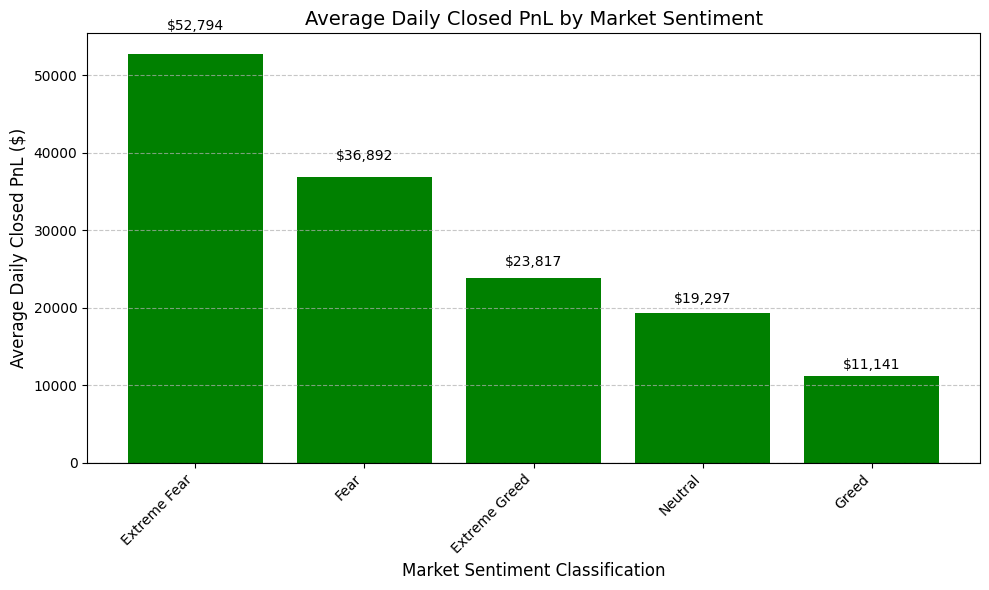

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Set display options for better visibility
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)

print("Starting Data Analysis Script...")

# --------------------------------------------------------------------------
# SECTION 1: DATA LOADING, CLEANING, AND MERGING
# --------------------------------------------------------------------------

# Load datasets. Ensure these are in the same folder as your script.
try:
    fear_greed_df = pd.read_csv("fear_greed_index.csv")
    trader_data_df = pd.read_csv("historical_data (1).csv")
except FileNotFoundError as e:
    print(f"\nCRITICAL ERROR: Input file not found: {e}")
    print("Please ensure your two CSV files are in the same directory.")
    exit()


# 1. Clean Fear & Greed Index Data
fear_greed_df['Date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_daily = fear_greed_df[['Date', 'classification']].rename(
    columns={'classification': 'Sentiment Classification'}
)

# 2. Clean Historical Trader Data
trader_data_df['Closed PnL'] = pd.to_numeric(trader_data_df['Closed PnL'], errors='coerce')

# Drop rows with missing critical values
# NOTE: The 'leverage' column was missing from the file and has been excluded from the analysis.
trader_data_df.dropna(subset=['Closed PnL', 'Timestamp IST', 'Size USD'], inplace=True)

# Convert timestamp and extract date
# Ensure the timestamp format is correct for the 'dayfirst=True' setting
trader_data_df['Timestamp IST'] = pd.to_datetime(trader_data_df['Timestamp IST'], dayfirst=True)
trader_data_df['Date'] = trader_data_df['Timestamp IST'].dt.normalize()

# 3. Daily Performance Aggregation and Merging
daily_performance = trader_data_df.groupby('Date').agg(
    Total_Closed_PnL=('Closed PnL', 'sum'),
    Total_Trades=('Account', 'size'),
    Daily_Win_Rate=('Closed PnL', lambda x: (x > 0).sum() / len(x)),
    Total_Volume_USD=('Size USD', 'sum'),
).reset_index()

merged_df = daily_performance.merge(fear_greed_daily, on='Date', how='inner')
print("Data Preparation Complete. Starting Analysis.")


# --------------------------------------------------------------------------
# SECTION 2: ANALYSIS 1 & 2 (SENTIMENT & SIDE ANALYSIS)
# --------------------------------------------------------------------------

# Analysis 1: Overall Sentiment Performance
sentiment_analysis = merged_df.groupby('Sentiment Classification').agg(
    Total_PnL=('Total_Closed_PnL', 'sum'),
    Average_Daily_PnL=('Total_Closed_PnL', 'mean'),
    Total_Trades=('Total_Trades', 'sum'),
    Total_Volume=('Total_Volume_USD', 'sum'),
    Average_Daily_Win_Rate=('Daily_Win_Rate', 'mean'),
    Number_of_Days=('Date', 'size')
).sort_values(by='Average_Daily_PnL', ascending=False)

# FIXED: Accessing 'Average_Daily_Win_Rate' instead of the old 'Daily_Win_Rate'
sentiment_analysis['Average_Daily_Win_Rate'] = (sentiment_analysis['Average_Daily_Win_Rate'] * 100)

print("\n--- [Result 1] Overall Performance by Market Sentiment ---")
print(sentiment_analysis.to_string())


# Analysis 2: PnL by Side & Sentiment (Deep Dive)
daily_side_performance = trader_data_df.groupby(['Date', 'Side']).agg(
    Total_PnL=('Closed PnL', 'sum'),
    Total_Trades=('Account', 'size')
).reset_index()

merged_side_df = daily_side_performance.merge(fear_greed_daily, on='Date', how='inner')
sentiment_side_analysis = merged_side_df.groupby(['Sentiment Classification', 'Side']).agg(
    Total_PnL=('Total_PnL', 'sum'),
    Total_Trades=('Total_Trades', 'sum')
).reset_index()

# Ensure correct calculation and naming of days per sentiment
days_per_sentiment = fear_greed_daily.groupby('Sentiment Classification')['Date'].size().reset_index(name='Number_of_Days')
sentiment_side_analysis = sentiment_side_analysis.merge(days_per_sentiment, on='Sentiment Classification')

# Calculate Average Daily PnL using the corrected column name 'Number_of_Days'
sentiment_side_analysis['Average_Daily_PnL'] = sentiment_side_analysis['Total_PnL'] / sentiment_side_analysis['Number_of_Days']

# Reorder and print PnL by Side
sentiment_order = ['Extreme Greed', 'Greed', 'Neutral', 'Fear', 'Extreme Fear']
sentiment_side_analysis['Sentiment Classification'] = pd.Categorical(
    sentiment_side_analysis['Sentiment Classification'], 
    categories=sentiment_order, 
    ordered=True
)
sentiment_side_analysis = sentiment_side_analysis.sort_values(by=['Sentiment Classification', 'Side'])

print("\n--- [Result 2] PnL by Sentiment and Trade Side (Strategy Insight) ---")
print(sentiment_side_analysis.to_string(index=False))


# --------------------------------------------------------------------------
# SECTION 3: VISUALIZATION
# --------------------------------------------------------------------------

print("\n--- SECTION 3: Visualization ---")

# 1. Create the output directory if it doesn't exist
output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

# 2. Prepare data for the required Average Daily PnL chart
plot_data = sentiment_analysis.reset_index()[['Sentiment Classification', 'Average_Daily_PnL']]

plot_data['Color'] = np.where(plot_data['Average_Daily_PnL'] > 0, 'green', 'red')

plt.figure(figsize=(10, 6))
bars = plt.bar(
    plot_data['Sentiment Classification'], 
    plot_data['Average_Daily_PnL'], 
    color=plot_data['Color']
)

plt.title('Average Daily Closed PnL by Market Sentiment', fontsize=14)
plt.xlabel('Market Sentiment Classification', fontsize=12)
plt.ylabel('Average Daily Closed PnL ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8) # Fixed line

# Adding labels on bars
for bar in bars:
    yval = bar.get_height()
    # Adjust vertical offset based on sign for readability
    vertical_offset = abs(yval) * 0.05 
    plt.text(bar.get_x() + bar.get_width()/2, 
             yval + (vertical_offset if yval >= 0 else -vertical_offset), 
             f'${yval:,.0f}', 
             ha='center', va='bottom' if yval >= 0 else 'top',
             fontsize=10, 
             color='black')

plt.tight_layout()

# SAVE THE CHART TO THE REQUIRED OUTPUT FOLDER
try:
    plt.savefig(f'{output_dir}/average_daily_pnl_by_sentiment.png')
except Exception as e:
    print(f"Error saving chart: {e}")
    print("Check permissions or folder path.")

print("\n--- Final Step Complete ---")
print(f"Chart saved to: {output_dir}/average_daily_pnl_by_sentiment.png")
print("All analysis is complete and ready for the ds_report.pdf.")